In [1]:
%matplotlib inline
#%matplotlib agg

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import matplotlib
from matplotlib import animation, rc
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128

import IPython.display as ipd

from IPython.core.display import HTML
def css_styling():
    styles = open("style.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()

import SchemDraw as schem
import SchemDraw.elements as e
from SchemDraw import dsp
from SchemDraw import flow

# some help from:
# http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/

# Ideal String with two Delay Lines


Based on the previously introduced discrete solution for the wave equation,
an ideal, lossless string can be implemented using two delay lines with direct coupling.
The left-traveling and right-traveling wave are connected end-to-end.
Output samples of each delay line are direcly inserted to the input of the counterpart:

 


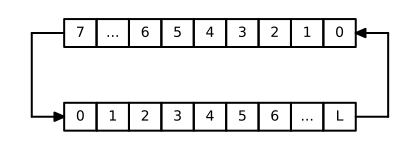

In [2]:
d = schem.Drawing(unit=1, fontsize=14)

d.push()
d.add(e.LINE, d='r')

d.add(dsp.BOX, label='7')
d.add(dsp.BOX, label='...')
d.add(dsp.BOX, label='6')
d.add(dsp.BOX, label='5')
d.add(dsp.BOX, label='4')
d.add(dsp.BOX, label='3')
d.add(dsp.BOX, label='2')
d.add(dsp.BOX, label='1')
d.add(dsp.BOX, label='0')

d.pop()

d.add(e.LINE, l=3, d='d')
d.add(e.LINE, d='r')
d.add(e.ARROWHEAD)

d.add(dsp.BOX, label='0')
d.add(dsp.BOX, label='1')
d.add(dsp.BOX, label='2')
d.add(dsp.BOX, label='3')
d.add(dsp.BOX, label='4')
d.add(dsp.BOX, label='5')
d.add(dsp.BOX, label='6')
d.add(dsp.BOX, label='...')
d.add(dsp.BOX, label='L')

#d.add(e.ARROWHEAD,label='$y[n]$')

d.add(e.LINE, d='r')
d.add(e.LINE, l=3, d='u')
d.add(e.LINE, d='l')
d.add(e.ARROWHEAD)

d.draw();


In [3]:
###################################################################
# function for plucking the string

def pluck(L,P):
    
    x_L = np.zeros(L);
    x_R = np.zeros(L);
    
    x_L[0:P] = np.linspace(0,1,P)
    x_R[0:P] = np.linspace(0,1,P)
    
    x_L[P:L-1] = np.linspace(1,0,L-P-1)
    x_R[P:L-1] = np.linspace(1,0,L-P-1)
    
    return x_L, x_R

-----

# The Excitation Function

The waveguides can be initiated - or excited - with any arbitrary function. 
This may vary, depending on the excitation principle of the instrument to be modeled.
For a plucked string, the excitation can be a triangular function with a maximum at the plucking point $p$.
Both waveguides (left/right travelling) are initiated with the same function:

$$y[i] = 
\begin{cases}
\frac{i}{p}         & \mbox{for } i \leq p \\
1-\frac{i-p}{N-p}   & \mbox{for } i > p \\
\end{cases}$$        

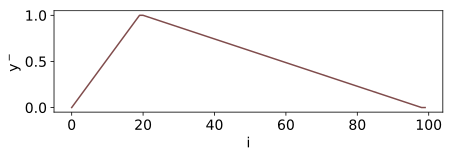

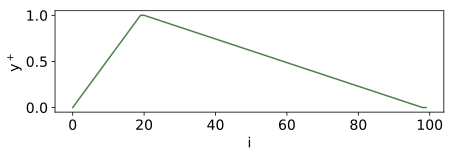

In [4]:
###################################################################

fs          = 48000

# length of the delay line:
L = 300
# feedback gain:
g = 0.95
# pluck position:
pluck_pos = 3
# pickup position:
pick = 5
# filter length:
N = 20

pick_pos = 10

x_L, x_R = pluck(100,20)


plt.subplot(2, 1, 1)
plt.plot(x_L, color=[0.5,0.3,0.3]);
plt.xlabel("$i$");
plt.ylabel("$y^-$");
plt.show();

plt.subplot(2, 1, 2)
plt.plot(x_R, color=[0.3,0.5,0.3]);
plt.xlabel("$i$");
plt.ylabel("$y^+$");
plt.show();




-----

# Oscillation


When both waveguides are shifted by one sample each $\frac{1}{f_s}$ seconds, the ideal string is oscillating
with a frequency of $f_0 = \frac{f_s}{N}$. It will oscillate continuously. In fact it is a superimposition of two oscillators with the waveform defined by the excitation function.

In [5]:


###################################################################

fs        = 48000

# length of the delay lines:
L         = 300

# feedback gain:
g         = 0.95

# pluck position:
pluck_pos = 3

# pickup position:
pick      = 5

# filter length:
N         = 20

pick_pos  = 10

n_out     = 300

x_L, x_R  = pluck(L,20)


y    = np.array([])

# the filter is a simple moving average
filt = np.zeros(N)


###################################################################

fig    = plt.figure()
fig.tight_layout(pad=3.0)

ax     = fig.add_subplot(2, 1, 1)
line,  = ax.plot(x_L,color=[0.5,0.3,0.3]);
#ax.set_title('Left-travelling Delay Line')
ax.set_xlabel("$i$");
ax.set_ylabel("$y^+$");
ax.set_ylim([-1, 1])


ax2    = fig.add_subplot(2, 1, 2)
rplot, = ax2.plot(x_R,color=[0.3,0.5,0.3]);
#ax2.set_title('Right-travelling Delay Line')
ax2.set_xlabel("$i$");
ax2.set_ylabel("$y^-$");
ax2.set_ylim([-1, 1])


###################################################################
# function: - get the next output sample
#           - shift all buffers

def next_step(x_L, x_R, filt, g, pick):
    
    # delay line outputs
    l_out = x_L[0]
    r_out = x_R[len(x_R)-1]    
    
    
    # shift all arrays
    x_L   = np.roll(x_L,-1)
    x_R   = np.roll(x_R,1)    
   
    
    # insert output values
    x_L[len(x_L)-1] = -r_out
    x_R[0]          = -l_out
    
    out =  x_L[pick] + x_R[pick]
    
    return x_L, x_R, filt, out


###################################################################
 

def animate(frame):
       
    global x_L
    global x_R
    global y
    global filt
    global line
    global L
    global pick_pos
    global g
    global fig 
    
    # print(y)
    # print(x_L[0:5])

    # for idx in(i):

    x_L, x_R, filt, out = next_step(x_L, x_R, filt, g, pick_pos)
    y = np.append(y,out)

    line.set_data(np.linspace(0, L, L), x_L)
    rplot.set_data(np.linspace(0, L, L), x_R)
 
    #print(len(x_L))
    return (line,)    


###################################################################

def init():
    
    global line
    
    line.set_data([], [])
    return (line,)


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=2*L, interval=100, 
                               blit=True)

plt.close();

HTML(anim.to_jshtml())
#HTML(anim.to_html5_video());

